# Shapley Values from Scratch

In [1]:
import matplotlib.pyplot as plt

plt.style.use("style.mplstyle")

## Load and Prepare Data

In [2]:
import pandas as pd

features = ["% working class", "number of rooms", "NOX concentration"]
df = pd.read_csv("data.csv")
y = df["y"].values
print(f"{len(y)} rows")
print(df[features + ["y"]].sample(5, random_state=0))

# returns:
# 506 rows
#      % working class  number of rooms  NOX concentration        y
# 329            14.68            6.333              0.460  22600.0
# 371            19.06            6.216              0.631  50000.0
# 219            21.00            6.373              0.550  23000.0
# 403            39.54            5.349              0.693   8300.0
# 78             24.68            6.232              0.437  21200.0

506 rows
     % working class  number of rooms  NOX concentration        y
329            14.68            6.333              0.460  22600.0
371            19.06            6.216              0.631  50000.0
219            21.00            6.373              0.550  23000.0
403            39.54            5.349              0.693   8300.0
78             24.68            6.232              0.437  21200.0


## Train Models

In [3]:
from sklearn.ensemble import RandomForestRegressor

models = {}

# Model with no features
models["none"] = [y.mean()] * len(y)

# models with one feature
for feature in features:
    X = df[feature].values.reshape(-1, 1)
    m = RandomForestRegressor(random_state=0).fit(X, y)
    models[feature] = m.predict(X)
    
# models with two features
models_two = {}
for i, feature1 in enumerate(features):
    for feature2 in features[i+1:]:
        X = df[[feature1, feature2]].values
        m = RandomForestRegressor(random_state=0).fit(X, y)
        models[f"{feature1}, {feature2}"] = m.predict(X)
        
# model with all features
X_all = df[features]
m = RandomForestRegressor(random_state=0).fit(X_all, y)
models["all"] = m.predict(X_all)

## Calculate Shapley Values

In [4]:
sv_pwc = 1/3 * (models["% working class"] - 
                models["none"]) +\
         1/6 * (models["% working class, number of rooms"] - 
                models["number of rooms"]) +\
         1/6 * (models["% working class, NOX concentration"] - 
                models["NOX concentration"]) +\
         1/3 * (models["all"] - 
                models["number of rooms, NOX concentration"])

sv_nor = 1/3 * (models["number of rooms"] - 
                models["none"]) +\
         1/6 * (models["% working class, number of rooms"] - 
                models["% working class"]) +\
         1/6 * (models["number of rooms, NOX concentration"] - 
                models["NOX concentration"]) +\
         1/3 * (models["all"] - 
                models["% working class, NOX concentration"])

sv_nc  = 1/3 * (models["NOX concentration"] - 
                models["none"]) +\
         1/6 * (models["% working class, NOX concentration"] - 
                models["% working class"]) +\
         1/6 * (models["number of rooms, NOX concentration"] - 
                models["number of rooms"]) +\
         1/3 * (models["all"] - 
                models["% working class, number of rooms"])

## Visualise Shapley Values

### Barplot of Mean Absolute Shapley Values

In [5]:
import numpy as np

print("Mean absolute shapley values:")
print(f"% working class  : {np.abs(sv_pwc).mean():,.1f}")
print(f"number of rooms  : {np.abs(sv_nor).mean():,.1f}")
print(f"NOX concentration: {np.abs(sv_nc).mean():,.1f}")

Mean absolute shapley values:
% working class  : 2,641.2
number of rooms  : 2,473.7
NOX concentration: 2,247.3


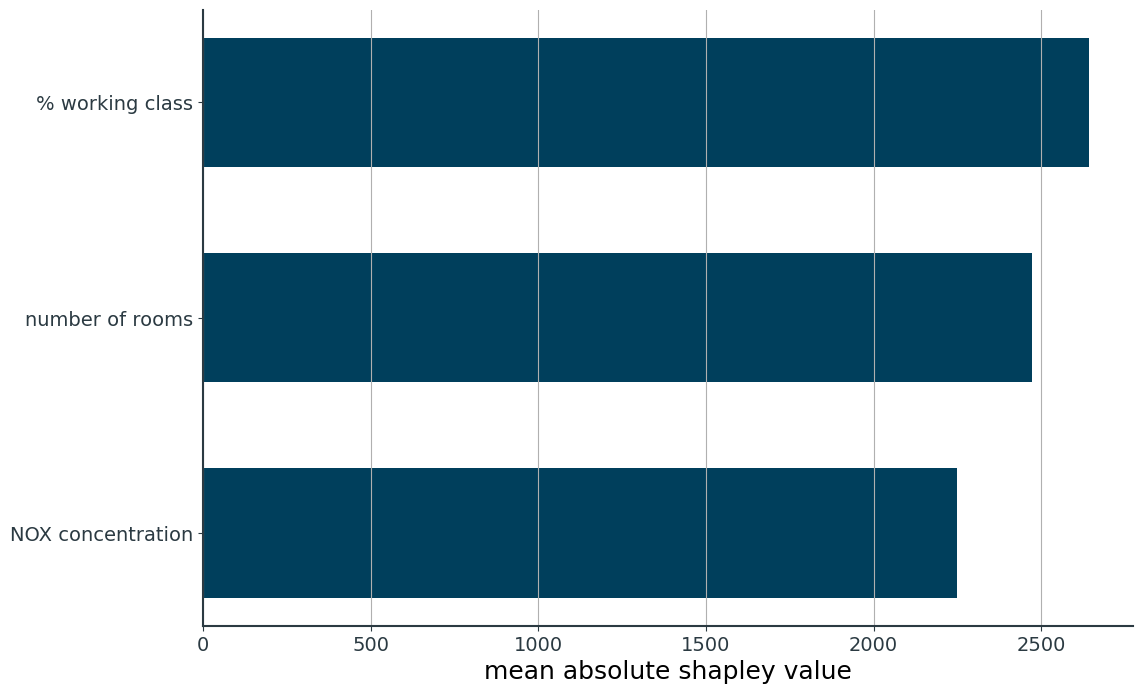

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.barh(
    ["NOX concentration", "number of rooms", "% working class"],
    [np.abs(sv_nc).mean(), np.abs(sv_nor).mean(), np.abs(sv_pwc).mean()],
    height=0.6,
)
ax.grid(axis="x")
ax.set_xlabel("mean absolute shapley value")
fig.savefig("plots/bar.png")

### Beeswarm Plot of Shapley Values

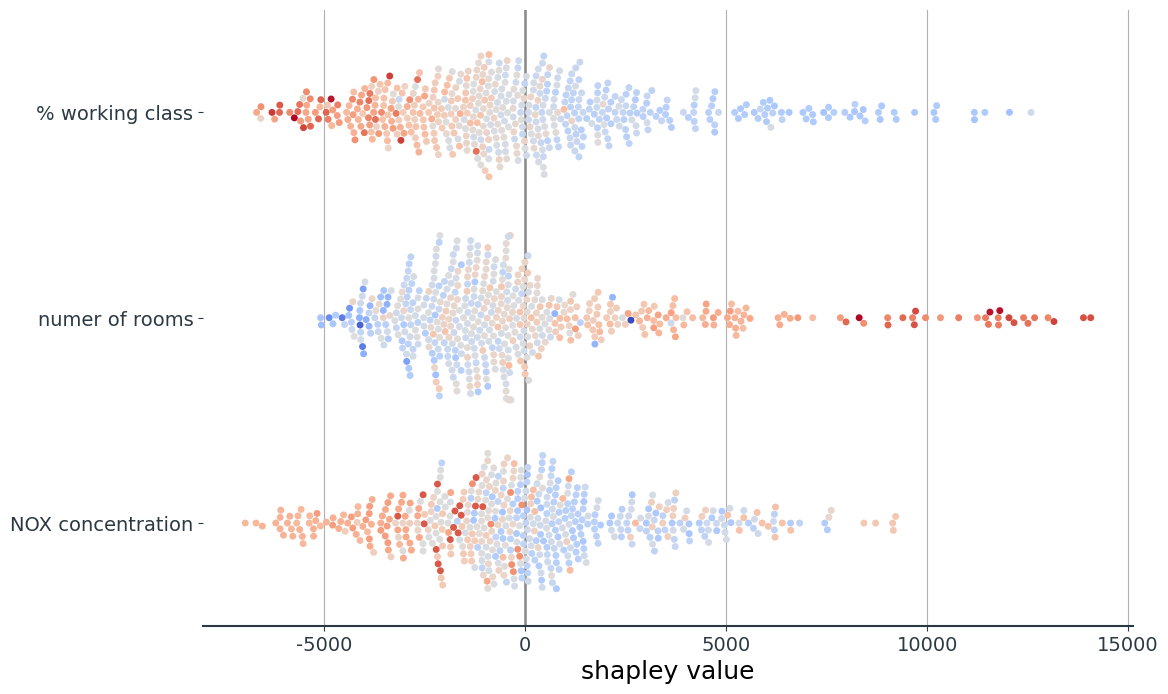

In [7]:
import seaborn as sns

# shape data for beeswarm plot
df_sv = pd.DataFrame()
df_sv["feature"] = (
    ["% working class"] * len(y)
    + ["numer of rooms"] * len(y)
    + ["NOX concentration"] * len(y)
)
df_sv["shapley value"] = np.concatenate([sv_pwc, sv_nor, sv_nc])
df_sv["hue"] = np.concatenate(
    [
        (df["% working class"].values - df["% working class"].mean())
        / df["% working class"].std(),
        (df["number of rooms"].values - df["number of rooms"].mean())
        / df["number of rooms"].std(),
        (df["NOX concentration"].values - df["NOX concentration"].mean())
        / df["NOX concentration"].std(),
    ]
)
df_sv

# beeswarm plot
fig, ax = plt.subplots()
ax.axvline(0, c="grey", alpha=0.8)
ax = sns.swarmplot(
    x=df_sv["shapley value"],
    y=df_sv["feature"],
    hue=df_sv["hue"],
    palette="coolwarm",  # red = higher raw value; blue = lower raw value
    size=5,
    legend=False,
)
ax.spines.left.set_visible(False)
ax.grid(axis="x")
ax.set_ylabel("")
fig.savefig("plots/beeswarm.png")